In [7]:
import time
from tqdm import tqdm
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class CustomClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc5(x)
        return x

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', ignore_mismatched_sizes=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

input_dim = model.classifier.in_features
num_classes = 7
model.classifier = CustomClassifier(input_dim, num_classes)
model.classifier.to(device)

c:\Users\zln92\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


CustomClassifier(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [9]:


for param in model.vit.parameters():
    param.requires_grad = False

optimizer = optim.Adam(model.classifier.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_dataset = datasets.ImageFolder(root='archive/train', transform=transform)
test_dataset = datasets.ImageFolder(root='archive/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc='Training')
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    progress_bar = tqdm(dataloader, desc='Evaluating')
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

num_epochs = 10
best_val_loss = float('inf')
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = evaluate(model, test_loader, criterion, device)
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Time: {epoch_duration:.2f}s")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print('-' * 30)
    
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_vit_fer2013.pth')
        print(f"Model saved with validation loss: {val_loss:.4f}")

print(f"Best model saved with validation loss: {best_val_loss:.4f}")

Evaluating: 100%|██████████| 225/225 [00:51<00:00,  4.37it/s, loss=1.2]  
c:\Users\zln92\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/10
Time: 310.08s
Train Loss: 1.4874
Validation Loss: 1.2650
Validation Accuracy: 0.5117
------------------------------
Model saved with validation loss: 1.2650


Evaluating: 100%|██████████| 225/225 [01:09<00:00,  3.24it/s, loss=1.01] 


Epoch 2/10
Time: 339.79s
Train Loss: 1.3089
Validation Loss: 1.1768
Validation Accuracy: 0.5593
------------------------------
Model saved with validation loss: 1.1768


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.01it/s, loss=0.761]


Epoch 3/10
Time: 204.87s
Train Loss: 1.2377
Validation Loss: 1.1264
Validation Accuracy: 0.5752
------------------------------
Model saved with validation loss: 1.1264


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  5.97it/s, loss=0.991]


Epoch 4/10
Time: 189.04s
Train Loss: 1.1976
Validation Loss: 1.1160
Validation Accuracy: 0.5768
------------------------------
Model saved with validation loss: 1.1160


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.91it/s, loss=0.826]


Epoch 5/10
Time: 192.50s
Train Loss: 1.1642
Validation Loss: 1.0798
Validation Accuracy: 0.5910
------------------------------
Model saved with validation loss: 1.0798


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  5.98it/s, loss=0.907]


Epoch 6/10
Time: 190.60s
Train Loss: 1.1388
Validation Loss: 1.0783
Validation Accuracy: 0.5935
------------------------------
Model saved with validation loss: 1.0783


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.83it/s, loss=0.632]


Epoch 7/10
Time: 193.39s
Train Loss: 1.1157
Validation Loss: 1.0589
Validation Accuracy: 0.6021
------------------------------
Model saved with validation loss: 1.0589


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.89it/s, loss=0.671]


Epoch 8/10
Time: 192.16s
Train Loss: 1.0966
Validation Loss: 1.0491
Validation Accuracy: 0.6032
------------------------------
Model saved with validation loss: 1.0491


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.89it/s, loss=0.505]


Epoch 9/10
Time: 191.67s
Train Loss: 1.0791
Validation Loss: 1.0320
Validation Accuracy: 0.6177
------------------------------
Model saved with validation loss: 1.0320


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  5.99it/s, loss=0.453]

Epoch 10/10
Time: 192.90s
Train Loss: 1.0601
Validation Loss: 1.0324
Validation Accuracy: 0.6144
------------------------------
Best model saved with validation loss: 1.0320


C:\Users\zln92\AppData\Local\Temp\ipykernel_4112\1806678823.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_accuracies, y=category_names, ax=ax, palette='viridis')


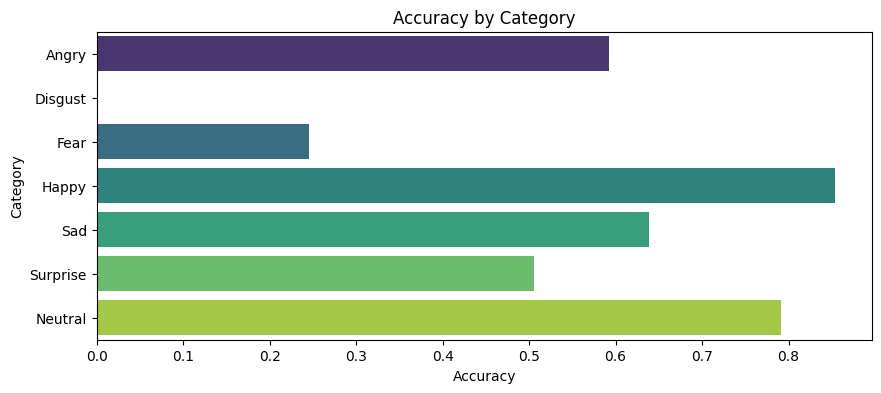

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score

def calculate_category_accuracies(model, dataloader, device, num_classes):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    category_accuracies = []
    for i in range(num_classes):
        category_mask = (np.array(true_labels) == i)
        category_acc = accuracy_score(np.array(true_labels)[category_mask], np.array(predicted_labels)[category_mask])
        category_accuracies.append(category_acc)

    return category_accuracies

category_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

category_accuracies = calculate_category_accuracies(model, test_loader, device, num_classes)

fig, ax = plt.subplots(figsize=(10, 4))  
sns.barplot(x=category_accuracies, y=category_names, ax=ax, palette='viridis')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Category')
ax.set_title('Accuracy by Category')
plt.show()

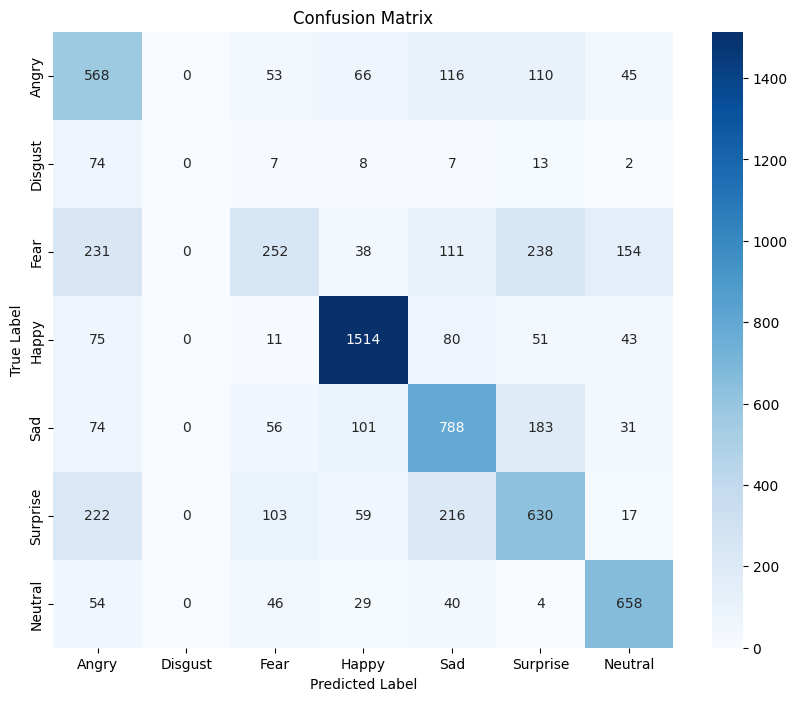

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader, device, num_classes, category_names):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, predicted_labels, labels=range(num_classes))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

category_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plot_confusion_matrix(model, test_loader, device, num_classes, category_names)